In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms 
import torchvision 
import torch.nn as nn
from sklearn.model_selection import train_test_split
import cv2
import os

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Download dataset

In [9]:
!git clone https://github.com/anminhhung/dog-cat-dataset

Cloning into 'dog-cat-dataset'...
remote: Enumerating objects: 25004, done.
remote: Total 25004 (delta 0), reused 0 (delta 0), pack-reused 25004
Receiving objects: 100% (25004/25004), 541.49 MiB | 12.12 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (25001/25001), done.


In [29]:
class DogCatDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.list_images_path = []
    self.list_labels = []
    self.one_hot_label = {"dogs": 0, "cats": 1}
    for sub_dir in os.listdir(root_dir):
      path_sub_dir = os.path.join(root_dir, sub_dir)
      for image_name in os.listdir(path_sub_dir):
        image_path = os.path.join(path_sub_dir, image_name)
        label = sub_dir
        self.list_images_path.append(image_path)
        self.list_labels.append(label)
    
    self.transform = transform
  
  def __len__(self):
    return len(self.list_images_path)
  
  def __getitem__(self, idx):
    image = cv2.imread(self.list_images_path[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image.astype('float')
    label = np.array(self.one_hot_label[self.list_labels[idx]]).astype('float')

    sample = (image, label)
    if self.transform:
      sample = self.transform(sample)
    
    return sample # image, label

In [30]:
class convertToTensor:
  def __call__(self, sample):
    image, label = sample

    # opencv image: H x W x C
    # torch tensor: C x H x W
    image = torch.from_numpy(image).permute(2, 0, 1).float()
    label = torch.from_numpy(label).long()

    return (image, label)

In [31]:
transformed_train_data = DogCatDataset('dog-cat-dataset/data/train', transform=transforms.Compose([convertToTensor()]))
transformed_test_data = DogCatDataset('dog-cat-dataset/data/test', transform=transforms.Compose([convertToTensor()]))

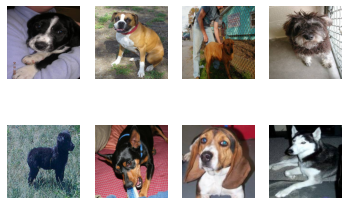

In [32]:
col = 4
row = 2

fig = plt.figure()
for index in range(1, col*row + 1):
  plt.subplot(row, col, index)
  plt.axis('off')
  plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(transformed_train_data.list_images_path[index]), cv2.COLOR_BGR2RGB), (224, 224)))

In [57]:
train_data_loader = DataLoader(transformed_train_data, batch_size=32, shuffle=True)
test_data_loader = DataLoader(transformed_test_data, batch_size=32, shuffle=True)

# ALexNet

In [40]:
class AlexNet(nn.Module):
  def __init__(self, n_classes):
    super(AlexNet, self).__init__()

    self.feature_extractor = nn.Sequential(
      # convolutional layers 1
      nn.Conv2d(in_channels=3, out_channels=16, kernel_size=11, stride=1),
      nn.ReLU(),
      nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
      nn.MaxPool2d(kernel_size=3, stride=1),
      # convolutional layers 2
      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
      nn.ReLU(),
      nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
      nn.MaxPool2d(kernel_size=3, stride=1),
      # convolutional layers 3
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
      nn.ReLU(),
      # convolutional layers 4
      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
      nn.ReLU(),
      # convolutional layers 1
      nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=3, stride=2)
    )

    self.flatten = nn.Flatten() 

    self.classifier = nn.Sequential(
      nn.Linear(in_features=313632, out_features=256),
      nn.ReLU(),
      nn.Linear(in_features=256, out_features=128),
      nn.ReLU(),
      nn.Linear(in_features=128, out_features=n_classes), 
    )

  def forward(self, x):
    output = self.feature_extractor(x)
    output = self.flatten(output)
    output = self.classifier(output)

    return output

In [58]:
model = AlexNet(2).to(device)

In [59]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()

# Train

In [60]:
'''
  Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
  correct = 0
  total = 0
  
  with torch.no_grad():
    model.eval()
    for images, labels in data_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  return 100*(correct/total)

'''
  Function for plotting training and validation losses
'''
def plot_losses(train_losses, valid_losses):
  # change the style of the plots to seaborn
  plt.style.use('seaborn')

  train_losses = np.array(train_losses)
  valid_losses = np.array(valid_losses)

  fig, ax = plt.subplots(figsize=(8, 4.5))

  ax.plot(train_losses, color="blue", label="Training_loss")
  ax.plot(valid_losses, color="red", label="Validation_loss")
  ax.set(title="Loss over epochs",
          xlabel="Epoch",
          ylabel="Loss")
  ax.legend()
  fig.show()

  # change the plot style to default
  plt.style.use('default')

'''
  function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
  model.train()
  running_loss = 0

  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    # forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()

    # backward and optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader)

  return model, optimizer, epoch_loss 

'''
  function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
  model.eval()
  running_loss = 0

  for images, labels in valid_loader:
    images = images.to(device)
    labels = labels.to(device)

    # forward pass and record loss
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss = loss.item()
  
  epoch_loss = running_loss / len(valid_loader)

  return model, epoch_loss

'''
  function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
  # set object for storing metrics
  best_loss = 1e10
  train_losses = []
  valid_losses = []

  # train model
  for epoch in range(0, epochs):
    # training
    model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)

    # validation
    with torch.no_grad():
      model, valid_loss = validate(valid_loader, model, criterion, device)
      valid_losses.append(valid_loss)

    if epoch % print_every == print_every - 1:
      train_acc = get_accuracy(model, train_loader, device=device)
      valid_acc = get_accuracy(model, valid_loader, device=device)

      print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
            epoch, train_loss, valid_loss, train_acc, valid_acc
            ))

  plot_losses(train_losses, valid_losses)

  return model, optimizer, (train_losses, valid_losses)

Epochs: 0, Train_loss: 0.6146079736232758, Valid_loss: 0.003897312720110462, Train_accuracy: 73.31, Valid_accuracy: 71.22
Epochs: 1, Train_loss: 0.4888429438591003, Valid_loss: 0.0038724317672146355, Train_accuracy: 80.255, Valid_accuracy: 75.72
Epochs: 2, Train_loss: 0.4122934839963913, Valid_loss: 0.0026326471832907126, Train_accuracy: 85.26, Valid_accuracy: 77.94
Epochs: 3, Train_loss: 0.3291758695363998, Valid_loss: 0.007065000048108921, Train_accuracy: 91.42, Valid_accuracy: 79.0
Epochs: 4, Train_loss: 0.22371556652784347, Valid_loss: 0.0037260142860898546, Train_accuracy: 92.75, Valid_accuracy: 75.52


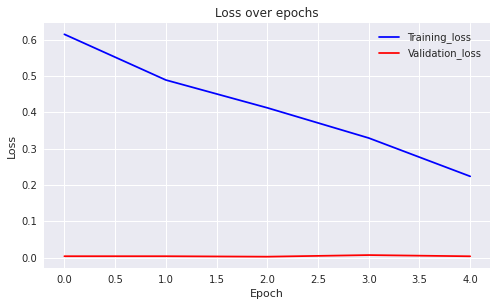

In [61]:
model, optimizer, _ = training_loop(model, loss_function, optimizer, train_data_loader, test_data_loader, 5, device)